In [4]:
#configure the necessary Spark environment
import os, sys

#del os.environ['PYSPARK_SUBMIT_ARGS']

#here you should set where are located the spark files
spark_home = '/home/vagrant/spark-2.0.2-bin-hadoop2.7/'

os.environ["SPARK_HOME"]  = spark_home

sys.path.insert(0, spark_home + "/python")

sys.path.insert(0, os.path.join(spark_home, 'python/lib/py4j-0.10.3-src.zip'))

#this defines the sparkContext sc
execfile(os.path.join(spark_home, 'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 2.0.2
      /_/

Using Python version 2.7.12 (default, Jul  1 2016 15:12:24)
SparkSession available as 'spark'.


In [5]:
%matplotlib inline
import datetime
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, DateFormatter
import numpy as np
from tabulate import tabulate

/usr/lib/python2.7/dist-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [6]:
interactions_file = sc.textFile('../data/interactions.psv')
interactions_header = interactions_file.first()

products_file = sc.textFile('../data/products.psv')
products_header = products_file.first()

interactions = (interactions_file
                .filter(lambda l: l != interactions_header)
                .map(lambda l: l.split("|"))
                .map(lambda l: (l[2], [l[0], l[1], l[3], l[4], datetime.datetime.fromtimestamp(int(l[5])/1000.0).replace(minute=0, hour=0, second=0, microsecond=0) ]))
                )
products = (products_file
            .filter(lambda l: l != products_header)
            .map(lambda l: l.split("|"))
            .map(lambda l: (l[0], [l[1], l[2], l[3], l[4], float(l[5])  ]))
            )

In [7]:
interactions_products = (interactions.join(products)
                             .map(lambda x: ((x[0], x[1][0][1], x[1][0][2], x[1][1][0], x[1][1][2], x[1][1][3]), 1))
                             .reduceByKey(lambda a,b: a+b)
                             .collect()
                         )
#'pid', 'action', 'channel', 'name','department', 'brand'      

In [8]:
interactions_by_productRDD = sc.parallelize(interactions_products)

### Type of interaction

In [9]:
type_count = (interactions_by_productRDD
                .map(lambda x: (x[0][1], x[1]))
                .reduceByKey(lambda a,b: a+b)
                .collect()
              )

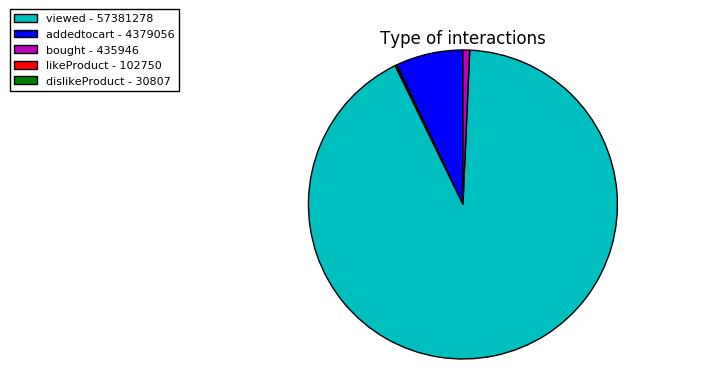

In [10]:
labels = [x[0] for x in type_count]
sizes = np.array([x[1] for x in type_count])
patches, texts = plt.pie(sizes, startangle=90, radius=1.2)
labels = ['{0} - {1}'.format(i,j) for i,j in zip(labels, sizes)]
patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)



plt.axis('equal')
plt.title('Type of interactions')
plt.show()

### Interactios by channel

Total by channel
------------------  --------
desktop site        35926052
mobile site         20384802
mobile application   4727326
unknown              1291657
------------------  --------




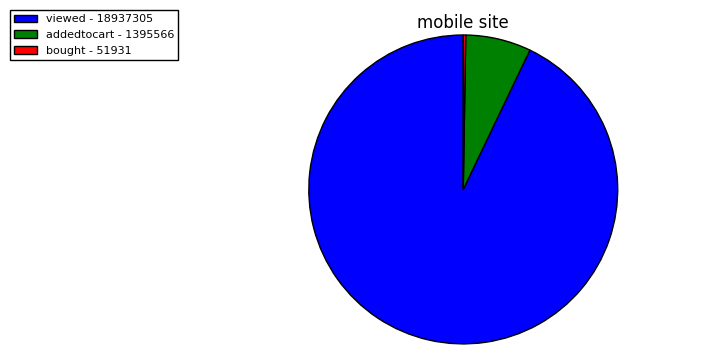

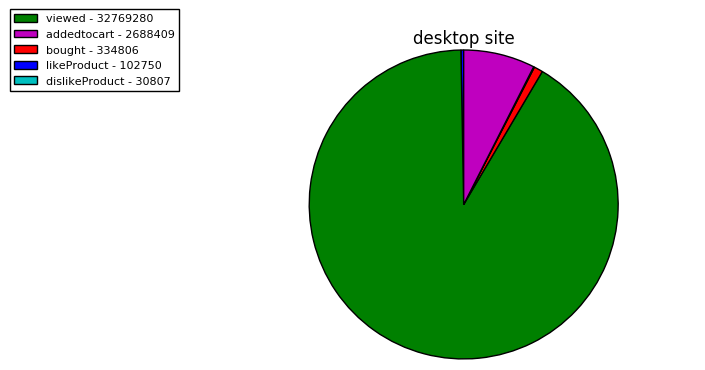

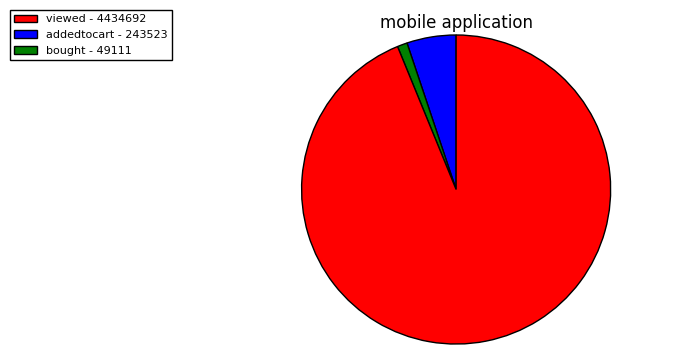

In [11]:
inter_by_channel_total = (interactions_by_productRDD
                            .map(lambda x: (x[0][2], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(1000, lambda x: -x[1])
)
print "Total by channel"
print tabulate(inter_by_channel_total)
print "\n"

inter_by_channel = (interactions_by_productRDD
                        .map(lambda x: ((x[0][2], x[0][1]), x[1]))
                        .reduceByKey(lambda a,b: a+b))
types = inter_by_channel.filter(lambda x: x[0][0] != u'unknown').map(lambda x: x[0][0]).distinct().collect()
for type in types:
    inter_by_type = inter_by_channel.filter(lambda x: x[0][0]==type).map(lambda x: (x[0][1], x[1])).collect()
    labels = [x[0] for x in inter_by_type]
    sizes = np.array([x[1] for x in inter_by_type])
    patches, texts = plt.pie(sizes, startangle=90, radius=1.2)
    labels = ['{0} - {1}'.format(i,j) for i,j in zip(labels, sizes)]
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, sizes),
                                              key=lambda x: x[2],
                                              reverse=True))

    plt.legend(patches, labels, loc='right', bbox_to_anchor=(-0.1, 1.),
               fontsize=8)



    plt.axis('equal')
    plt.title(type)
    plt.show()
    print "\n\n\n"
    

In [12]:
print float(51931)/1395566*100
print float(49111)/243523*100
print float(334806)/2688409*100
print '\n'
print float(51931)/18937305*100
print float(334806)/32769280*100
print float(49111)/4434692*100

3.72114253285
20.1668836208
12.4536854325


0.274225926023
1.02170691575
1.10742752823


# Moblie site has 5 times more interactions than the mobile app


## Add to chart and buy
### mobile site: 3,72%
### mobile app: 20,16%
### desktop site: 12,45%

The mobile site has a low rate of completed purchases which suggests the user experience could be bad

## Conversion rate
### mobile site: 0,27%
### mobile app: 1,02%
### desktop site: 1.10%
The mobile site conversion rate supports the hypothesis that the user experience is bad

### Most interacted products - Top 20

In [13]:
most_interacted_products = (interactions_by_productRDD
                            .map(lambda x: (x[0][3], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(20, lambda x: -x[1])
                            )

print tabulate(most_interacted_products)

----------------------------------------------------  ------
smartphone samsung galaxy j5 duos dual chip 16gb      693939
smartphone samsung galaxy j7 duos dual chip 16gb      681338
iphone 5s apple 16gb ios 8 tela 4 4g wifi             648027
smartphone samsung galaxy a5 duos dual chip 4g        634124
smartphone samsung galaxy gran prime duos 8gb         471619
smartphone motorola moto g 3deg geracao colors hdtv   464310
smartphone samsung galaxy j1 mini dual chip 3g        438400
guardaroupa casal 4 portas com espelho 6 gavetas      371411
guardaroupa casal 3 portas de correr com espelho      363188
guardaroupa casal 2 portas de correr com espelho      334231
iphone 6 apple 16gb prata tela 47 retina 4g           302765
smartphone lenovo vibe k5 16gb dual chip 4g           302668
smartphone samsung galaxy gran prime duos tv 8gb      299872
sofa retratil e reclinavel 3 lugares suede montana    292702
smartphone positivo selfie s455 8gb dual chip 3g      290184
"""tv led 32"""" samsung

### Most viewed, bought and liked products - Top 10

In [14]:
#'pid', 'action', 'channel', 'name','department', 'brand'   
most_viewed_products = (interactions_by_productRDD
                            .filter(lambda x : x[0][1] == u'viewed')
                            .map(lambda x: (x[0][3], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(10, lambda x: -x[1])
                        )
print "Most viewed"
print tabulate(most_viewed_products)
most_bought_products = (interactions_by_productRDD
                            .filter(lambda x : x[0][1] == u'bought')
                            .map(lambda x: (x[0][3], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(10, lambda x: -x[1])
                        )

print "Most bought"
print tabulate(most_bought_products)

most_liked_products = (interactions_by_productRDD
                            .filter(lambda x : x[0][1] == u'likeProduct')
                            .map(lambda x: (x[0][3], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(10, lambda x: -x[1])
                        )

print "Most liked"
print tabulate(most_liked_products)

Most viewed
---------------------------------------------------  ------
smartphone samsung galaxy j5 duos dual chip 16gb     657295
smartphone samsung galaxy j7 duos dual chip 16gb     637492
iphone 5s apple 16gb ios 8 tela 4 4g wifi            601174
smartphone samsung galaxy a5 duos dual chip 4g       588495
smartphone samsung galaxy gran prime duos 8gb        446321
smartphone motorola moto g 3deg geracao colors hdtv  429164
smartphone samsung galaxy j1 mini dual chip 3g       392539
guardaroupa casal 4 portas com espelho 6 gavetas     352442
guardaroupa casal 3 portas de correr com espelho     351988
guardaroupa casal 2 portas de correr com espelho     320263
---------------------------------------------------  ------
Most bought
---------------------------------------------------  ----
smartphone samsung galaxy a5 duos dual chip 4g       5463
smartphone samsung galaxy j1 mini dual chip 3g       4825
jogo de toalha 4 pecas santista royal                3973
smartphone samsung galax

### Products with the best conversion rate (more than 1.000 views)

In [15]:
prod_rate_view = (interactions_by_productRDD
                    .filter(lambda x : x[0][1] == u'viewed')
                    .map(lambda x: (x[0][0], x[1]))
                    .reduceByKey(lambda a,b: a+b)
                    .filter(lambda x: x[1] > 1000)
)
prod_rate_bought = (interactions_by_productRDD
                    .filter(lambda x : x[0][1] == u'bought')
                    .map(lambda x: (x[0][0], x[1]))
                    .reduceByKey(lambda a,b: a+b)
)
prod_conversion_rate = (prod_rate_view
                            .join(prod_rate_bought)
                            .map(lambda x: (x[0], float(x[1][1])/x[1][0]*100))
                            .join(products)
                            .map(lambda x: (x[1][1][0], x[1][0], x[1][1][4]))
                            .takeOrdered(20, lambda x: -x[1])
)
print tabulate(prod_conversion_rate)

--------------------------------------------------  --------  -------
secador de cabelo gama italy potenza                21.9573   3.76
secador de cabelo taiff tourmaline ion ceramica     21.1562   4.82418
panificadora britania multi pane                    16.2553   4.72727
coifa de parede fogatti inox 75cm 3 velocidades     15.4406   0
microondas panasonic piccolo nnst354wrun 25l        13.3333   0
secador de cabelo taiff fox ion                     13.1134   4.76923
cafeteira expresso 15 bar tres coracoes mimo        12.9801   0
tanquinho colormaq lcb10 10kg                       11.2752   4.9
escova rotativa mondial er 03 modeladora ceramica   11.219    3.16667
escova modeladora e alisadora rotativa 900w          9.69325  3.61225
tanquinho colormaq lcm 15                            9.55357  4
lava e seca samsung wd106uhsawq 10kg                 9.24092  4.59091
lavadora de roupas samsung wf106u4sawqfaz            9.00025  4.64286
mquina de costura singer brilliance 6180           

In [16]:
prod_conversion_rate_corr = (prod_rate_view
                                .join(prod_rate_bought)
                                .map(lambda x: (x[0], float(x[1][1])/x[1][0]*100))
                                .join(products)
                                .map(lambda x: (x[1][0], x[1][1][4]))
                                .collect()
)

In [17]:
np.corrcoef([x[0] for x in prod_conversion_rate_corr], [x[1] for x in prod_conversion_rate_corr])[0, 1]

0.11111868897161881

The top 20 products with the best conversion rate aren't the more rated products, but we have a 0.1 correlation between rate and conversion

### Products with greater abandonment of purchase

In [19]:
prod_rate_add = (interactions_by_productRDD
                    .filter(lambda x : x[0][1] == u'addedtocart')
                    .map(lambda x: (x[0][0], x[1]))
                    .reduceByKey(lambda a,b: a+b)
                    .filter(lambda x: x[1] > 1000)
)

prod_abandonment_rate = (prod_rate_add
                            .join(prod_rate_bought)
                            .map(lambda x: (x[0], (1-float(x[1][1])/x[1][0])*100))
                            .join(products)
                            .map(lambda x: (x[1][1][0], x[1][0], x[1][1][4]))
                            .takeOrdered(20, lambda x: -x[1])
)
print tabulate(prod_abandonment_rate)

-------------------------------------------------  -------  -------
"""smart tv ultra hd 55"""" samsung un55hu7200"""  99.962   0
geladeira/refrigerador continental cycle defrost   99.8614  4.25
live gold card microsoft 12 meses                  99.8217  5
"""tv led 32"""" lg 32lf565b hdtv"""               99.801   5
espremedor de frutas mondial turbo citrus e-15     99.5231  3
smartphone sony xperia z3 compact 4g android 4.4   99.0578  5
forma retangular para bolo em vidro                99.0351  0
aparelho de jantar 42 pecas porcelana              98.5628  4.41379
forma retangular em vidro                          98.5127  5
escova rotativa conair conair titanium modeladora  98.3939  4.36842
cama box casal conjugado com bau 42cm de altura    98.3732  0
smartphone lg k10 16gb dual chip 4g cam. 13mp      98.3607  0
geladeirarefrigerador electrolux frost free inox   98.3325  5
smartphone motorola moto g music 3a geracao 4g     98.1255  4.66667
pote em vidro com tampa                    

### Most interacted departments

In [20]:
#'pid', 'action', 'channel', 'name','department', 'brand'    
most_interacted_departments = (interactions_by_productRDD
                                .map(lambda x: (x[0][4], x[1]))
                                .reduceByKey(lambda a,b: a+b)
                                .takeOrdered(20, lambda x: -x[1])
                             )
print tabulate(most_interacted_departments)

----------------------  --------
celulares e telefones   16591597
mveis e decorao         11858025
tv e video               5333165
eletrodomsticos          3333452
informtica               2567186
moveis e decoracao       2472039
beleza e saude           1684272
cama, mesa e banho       1676716
tablets                  1657046
utilidades domsticas     1484444
esporte e lazer          1423722
bebe                     1328812
eletroportteis           1059286
informatica              1033702
brinquedos               1009005
automotivo                962327
informtica e acessrios    809457
perfumaria                746680
udio                      621338
eletroportateis           473866
----------------------  --------


### Most viewed, bought and liked departments

In [21]:
#'pid', 'action', 'channel', 'name','department', 'brand'   
most_viewed_departments = (interactions_by_productRDD
                            .filter(lambda x : x[0][1] == u'viewed')
                            .map(lambda x: (x[0][4], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(10, lambda x: -x[1])
                         )
print "Most viewed"
print tabulate(most_viewed_departments)

most_bought_departments = (interactions_by_productRDD
                            .filter(lambda x : x[0][1] == u'bought')
                            .map(lambda x: (x[0][4], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(10, lambda x: -x[1])
                         )
print "Most bought"
print tabulate(most_bought_departments)

most_liked_departments = (interactions_by_productRDD
                            .filter(lambda x : x[0][1] == u'likeProduct')
                            .map(lambda x: (x[0][4], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(10, lambda x: -x[1])
                         )

print "Most liked"
print tabulate(most_liked_departments)

Most viewed
---------------------  --------
celulares e telefones  15626926
mveis e decorao        10994263
tv e video              4950364
eletrodomsticos         3082082
informtica              2442998
moveis e decoracao      2302290
tablets                 1528341
beleza e saude          1486812
esporte e lazer         1328284
cama, mesa e banho      1280590
---------------------  --------
Most bought
---------------------  -----
celulares e telefones  95986
mveis e decorao        53018
tv e video             29762
beleza e saude         26534
eletrodomsticos        23461
cama, mesa e banho     19878
tablets                16876
utilidades domsticas   16098
informtica             15774
bebe                   12938
---------------------  -----
Most liked
----------------------  -----
celulares e telefones   30418
mveis e decorao         15993
tv e video              10962
cama, mesa e banho      10155
utilidades domsticas     5676
informtica               2850
tablets                

### Departments with the best conversion rate (more than 1.000 views)

In [22]:
department_rate_view = (interactions_by_productRDD
                                .filter(lambda x : x[0][1] == u'viewed')
                                .map(lambda x: (x[0][4], x[1]))
                                .reduceByKey(lambda a,b: a+b)
                                .filter(lambda x: x[1] > 1000)
)

department_rate_bought = (interactions_by_productRDD
                    .filter(lambda x : x[0][1] == u'bought')
                    .map(lambda x: (x[0][4], x[1]))
                    .reduceByKey(lambda a,b: a+b)
)

department_conversion_rate = (department_rate_view
                            .join(department_rate_bought)
                            .map(lambda x: (x[0], float(x[1][1])/x[1][0]*100))
                            .takeOrdered(20, lambda x: -x[1])
)
print tabulate(department_conversion_rate)

------------------------  --------
telefonia fixa            2.29043
suplementos alimentares   1.97103
beleza e saude            1.78462
informatica e acessorios  1.75432
informtica e acessrios    1.71441
eletroportateis           1.56402
cama, mesa e banho        1.55225
utilidades domesticas     1.49068
livros                    1.47169
games                     1.46622
utilidades domsticas      1.29024
ar e ventilacao           1.26751
eletroportteis            1.17042
tablets                   1.1042
eletrodomesticos          1.10189
bebe                      1.08978
perfumaria                1.03969
brinquedos                0.937204
automotivo                0.893433
casa e jardim             0.850373
------------------------  --------


### Departments with greater abandonment of purchase

In [23]:
department_rate_add = (interactions_by_productRDD
                                .filter(lambda x : x[0][1] == u'addedtocart')
                                .map(lambda x: (x[0][4], x[1]))
                                .reduceByKey(lambda a,b: a+b)
                                .filter(lambda x: x[1] > 1000)
)

department_abandonment_rate = (department_rate_add
                            .join(department_rate_bought)
                            .map(lambda x: (x[0], (1-float(x[1][1])/x[1][0])*100))
                            .takeOrdered(20, lambda x: -x[1])
)
print tabulate(department_abandonment_rate)

-----------------------  -------
cama, mesa e banho       94.5592
moveis e decoracao       94.2386
mveis e decorao          93.3079
utilidades domsticas     92.4915
livros                   91.58
utilidades domesticas    91.5234
tv e video               91.2305
instrumentos musicais    90.6368
cameras e filmadoras     90.24
ferramentas e seguranca  90.1395
eletrodomesticos         90.137
automotivo               90.1354
suplementos alimentares  90.1224
perfumaria               90.1001
ar e ventilao            89.8342
bebe                     89.8153
eletrodomsticos          89.5777
eletroportateis          88.8162
brinquedos               88.7756
esporte e lazer          88.7392
-----------------------  -------


### Most interacted brands

In [24]:
#'pid', 'action', 'channel', 'name','department', 'brand'    
most_interacted_brands = (interactions_by_productRDD
                                .map(lambda x: (x[0][5], x[1]))
                                .reduceByKey(lambda a,b: a+b)
                                .takeOrdered(20, lambda x: -x[1])
                             )
print tabulate(most_interacted_brands)

----------  --------
samsung     10920228
lg           3388530
apple        3124535
motorola     2319555
araplac      1627787
lenovo       1575579
ortobom       962150
dell          906373
somopar       887365
positivo      865803
tramontina    849648
sony          783282
santista      777138
demobile      737761
acer          690591
madesa        681962
multilaser    675227
philips       667282
philco        626715
asus          578699
----------  --------


### Most viewed, bought and liked brands

In [25]:
#'pid', 'action', 'channel', 'name','department', 'brand'   
most_viewed_brands = (interactions_by_productRDD
                            .filter(lambda x : x[0][1] == u'viewed')
                            .map(lambda x: (x[0][5], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(10, lambda x: -x[1])
                         )
print "Most viewed"
print tabulate(most_viewed_brands)

most_bought_brands = (interactions_by_productRDD
                            .filter(lambda x : x[0][1] == u'bought')
                            .map(lambda x: (x[0][5], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(10, lambda x: -x[1])
                         )
print "Most bought"
print tabulate(most_bought_brands)

most_liked_brands = (interactions_by_productRDD
                            .filter(lambda x : x[0][1] == u'likeProduct')
                            .map(lambda x: (x[0][5], x[1]))
                            .reduceByKey(lambda a,b: a+b)
                            .takeOrdered(10, lambda x: -x[1])
                         )

print "Most liked"
print tabulate(most_liked_brands)

Most viewed
--------  --------
samsung   10231107
lg         3170199
apple      2968114
motorola   2195677
araplac    1522916
lenovo     1465453
dell        858753
ortobom     848635
somopar     830063
positivo    794132
--------  --------
Most bought
----------  -----
samsung     66170
lg          19068
lenovo      13624
motorola    11943
santista    11593
apple       11325
ortobom      9486
positivo     9183
tramontina   8928
epson        7846
----------  -----
Most liked
--------  -----
samsung   19082
santista   8522
lg         6194
apple      5127
positivo   4099
motorola   3470
ortobom    2847
araplac    2411
marinex    2403
lenovo     2003
--------  -----


### Brands with the best conversion rate (more than 1.000 views)

In [26]:
brand_rate_view = (interactions_by_productRDD
                                .filter(lambda x : x[0][1] == u'viewed')
                                .map(lambda x: (x[0][5], x[1]))
                                .reduceByKey(lambda a,b: a+b)
                                .filter(lambda x: x[1] > 1000)
)

brand_rate_bought = (interactions_by_productRDD
                    .filter(lambda x : x[0][1] == u'bought')
                    .map(lambda x: (x[0][5], x[1]))
                    .reduceByKey(lambda a,b: a+b)
)

brand_conversion_rate = (brand_rate_view
                            .join(brand_rate_bought)
                            .map(lambda x: (x[0], float(x[1][1])/x[1][0]*100))
                            .takeOrdered(20, lambda x: -x[1])
)
print tabulate(brand_conversion_rate)

------------------  -------
golden nutrition    4.79535
cuba paris          3.96354
mega bronze         3.8048
winmax              3.59444
bicho esperto       3.44828
wella               3.39908
skinceuticals       3.12966
alumnio ramos       3.08713
sterilair           3.0583
ada tina            3.02947
super billion hair  3.00353
fashion home        2.93863
clarins             2.91027
mojang              2.81057
buettner            2.7939
l?oreal paris       2.76019
lansinoh            2.75503
bandai namco        2.70645
john frieda         2.68034
senscience          2.66469
------------------  -------


### Brands with greater abandonment of purchase

In [28]:
brand_rate_add = (interactions_by_productRDD
                                .filter(lambda x : x[0][1] == u'addedtocart')
                                .map(lambda x: (x[0][5], x[1]))
                                .reduceByKey(lambda a,b: a+b)
                                .filter(lambda x: x[1] > 1000)
)

brand_abandonment_rate = (brand_rate_add
                            .join(brand_rate_bought)
                            .map(lambda x: (x[0], (1-float(x[1][1])/x[1][0])*100))
                            .takeOrdered(20, lambda x: -x[1])
)
print tabulate(brand_abandonment_rate)

--------------------  -------
continental           99.3338
caza nobre estofados  97.7318
thb                   97.579
marinex               97.4605
santos andira         97.3738
mveis estrela         97.2803
notebook              97.2503
carolina moveis       97.1963
conair                97.1171
moveis canaa          96.6667
multimveis            96.624
cotipls               96.5109
orion                 96.4465
casamob               96.4371
jw                    96.3462
kits parana           96.3121
estofados lima        96.2858
mamypoko              96.1734
nadir                 95.9812
design final          95.9214
--------------------  -------


# Conversion rate through time

In [29]:
interactions_viewed = (interactions
                             .filter(lambda x: x[1][1] == u'viewed' )
                             .map(lambda x: ( (x[1][4], x[1][2]), 1) )
                             .reduceByKey(lambda a,b: a+b)
)

interactions_bought = (interactions
                             .filter(lambda x: x[1][1] == u'bought' )
                             .map(lambda x: ( (x[1][4], x[1][2]), 1) )
                             .reduceByKey(lambda a,b: a+b)
)

conversion_rate_over_time = (interactions_viewed
    .join(interactions_bought)
    .map(lambda x : (x[0][0], x[0][1], x[1][1], x[1][0], float(x[1][1])/x[1][0]*100))
    .sortBy(lambda x: x[0])
    .collect()
)

In [44]:
types = set([r[1] for r in conversion_rate_over_time])
types.remove(u'unknown')
types

{u'desktop site', u'mobile application', u'mobile site'}

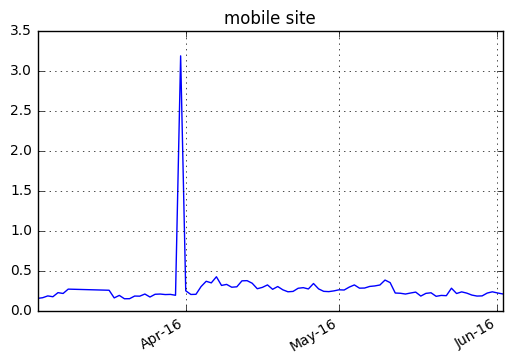

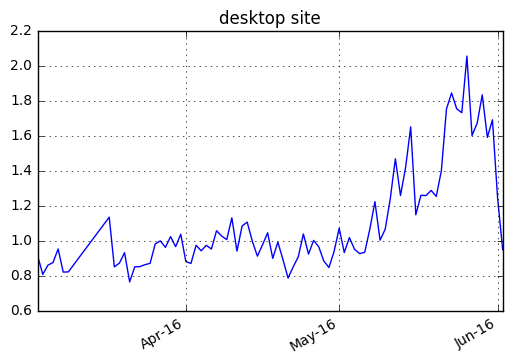

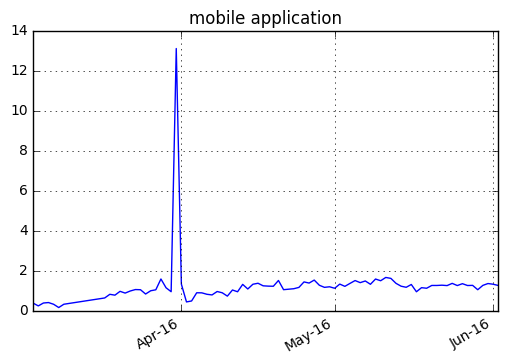

In [45]:
types = set([r[1] for r in conversion_rate_over_time])
types.remove(u'unknown')
for type in types:
    dates = [r[0] for r in conversion_rate_over_time if r[1] == type]
    rates = [r[4] for r in conversion_rate_over_time if r[1] == type]

    date1 = dates[0]
    date2 = dates[-1]

    fig, ax = plt.subplots()
    ax.plot_date(dates, rates, '-')
    ax.xaxis.set_major_locator( MonthLocator(range(1, 13), bymonthday=1, interval=1))
    ax.xaxis.set_major_formatter(DateFormatter("%b-%y"))
    ax.autoscale_view()
    ax.grid(True)
    plt.title(type)
    ax.set_ylim([0,15])
    fig.autofmt_xdate()

    plt.show()

### Lets take a deep look at Mar-16 on mobile site/app

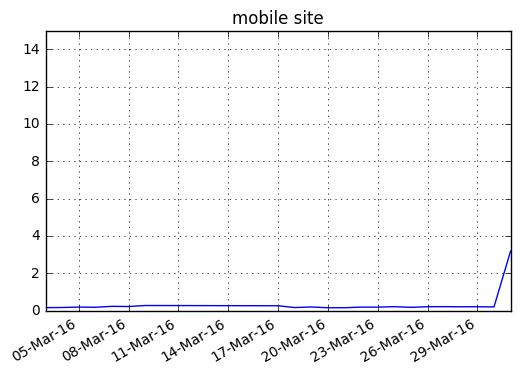

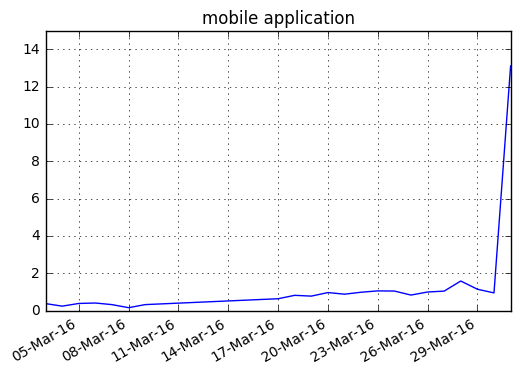

In [56]:
types = set([r[1] for r in conversion_rate_over_time])
types.remove(u'unknown')
types.remove(u'desktop site')
for type in types:
    dates = [r[0] for r in conversion_rate_over_time if r[1] == type and r[0].month == 3]
    rates = [r[4] for r in conversion_rate_over_time if r[1] == type and r[0].month == 3]

    date1 = dates[0]
    date2 = dates[-1]

    fig, ax = plt.subplots()
    ax.plot_date(dates, rates, '-')
    #ax.xaxis.set_major_locator( MonthLocator(range(1, 13), bymonthday=1, interval=1))
    ax.xaxis.set_major_formatter(DateFormatter("%d-%b-%y"))
    ax.autoscale_view()
    ax.grid(True)
    plt.title(type)
    ax.set_ylim([0,15])
    fig.autofmt_xdate()

    plt.show()

## On 31 March (Thursday) the conversion rate was the higher of the series of the mobile site/app
## What have Magazine done at this day?

# Let's go deeper on that day

In [74]:
march_31_interactions = (interactions
    .filter(lambda x: x[1][4].month == 3 and x[1][4].day>=29 and x[1][2] in [u'mobile site', u'mobile application'] )
    .map(lambda x: ( (x[1][4], x[1][2], x[1][1]), 1))
    .reduceByKey(lambda a,b: a+b)
    .sortBy(lambda x: (x[0][0], x[0][1], x[1][2]))
    .collect()
)
print tabulate(march_31_interactions)

### The number of views droped drasticaly on that day, but the number of purchases doens't, so do we have a problem with the data?